In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix

In [2]:
df = pd.read_csv("train.csv", low_memory = False)
# df.isnull().sum()
df

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0


In [3]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [4]:
df.columns

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [5]:
#converting all the data to lowercased
df['TITLE'] = df['TITLE'].str.lower()

In [6]:
df.describe()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,10486.500000,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873
std,6054.239259,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5243.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15729.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,20972.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
#removal of punctuation
import string, time
exclude = string.punctuation

In [8]:
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

In [9]:
df['TITLE'] = df['TITLE'].apply(remove_punc)

In [10]:
from nltk.corpus import stopwords

In [11]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [21]:
def recommend_titles(input_text, df):
    # Preprocess title column
    df['TITLE'] = df['TITLE'].str.strip()

    # Dimensionality Reduction
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    vector_matrix = vectorizer.fit_transform(df['TITLE'])
  
    # Convert to Sparse Matrix Representation
    vector_matrix_sparse = csr_matrix(vector_matrix)
    # Split input into individual words
    keywords = input_text.lower().split()

    # Initialize set to store recommended titles
    recommended_titles_set = set()

    # Iterate through each keyword
    for keyword in keywords:
        # Filter the dataset based on the keyword
        matching_indices = df[df['TITLE'].str.contains(keyword, case=False)].index
        if len(matching_indices) > 0:
            # Compute cosine similarity only for matching titles
            cosine_similarity_sparse = cosine_similarity(vector_matrix_sparse[matching_indices])

            # Get recommendations
            num_recommend = 10
            sorted_indices = np.argsort(cosine_similarity_sparse, axis=1)[:, ::-1]
            recommended_indices = sorted_indices[:, 1:num_recommend + 1]
            recommended_titles = df.iloc[matching_indices[recommended_indices.flatten()]]['TITLE'].values
            recommended_titles_set.update(recommended_titles)

    # Convert recommended titles set to a list
    recommended_titles_list = list(recommended_titles_set)[0:5]  # Get top 10 titles
    return recommended_titles_list

# Read the dataset

# Get user input
user_input = input("Enter a word or phrase to get recommendations: ")

# Call the function to get recommendations
recommended_titles = recommend_titles(user_input, df)

# Print recommended titles
print("\nRecommended Titles:")
for i, title in enumerate(recommended_titles):
    print(f"{i+1}. {title}")


Enter a word or phrase to get recommendations:  Neural Network



Recommended Titles:
1. gotwave temporal network alignment using graphletorbit transitions
2. information transmission and signal permutation in active flow networks
3. stochastic training of neural networks via successive convex approximations
4. on the erm principle with networked data
5. data noising as smoothing in neural network language models


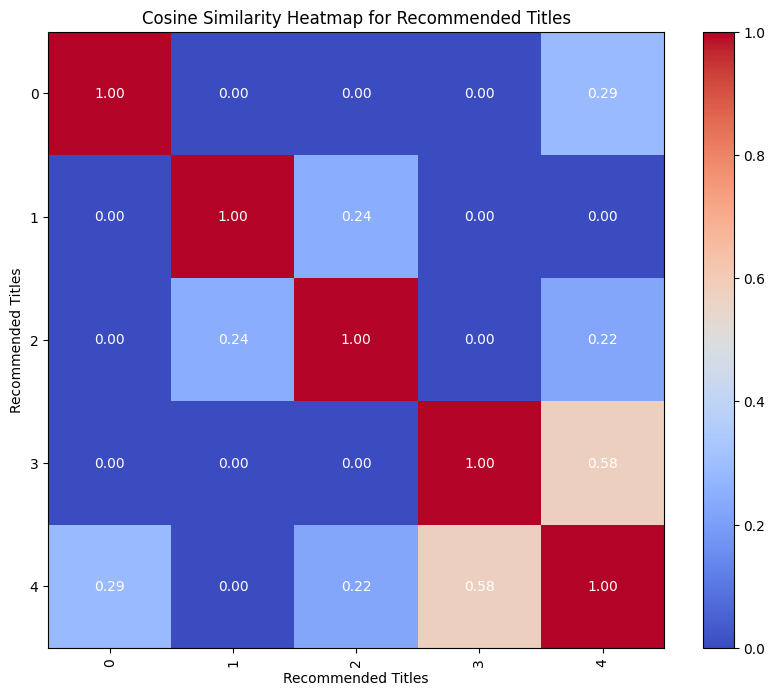

In [24]:
recommended_titles = [title.strip() for title in recommended_titles]

# Reduce Vector Dimensionality
vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
vector_matrix = vectorizer.fit_transform(recommended_titles)

# Convert to Sparse Matrix Representation
vector_matrix_sparse = csr_matrix(vector_matrix)

# Compute cosine similarity matrix for recommended titles
cosine_similarity_sparse = cosine_similarity(vector_matrix_sparse)

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cosine_similarity_sparse, cmap='coolwarm', interpolation='nearest', vmin = 0, vmax = 1)
plt.colorbar()
for i in range(cosine_similarity_sparse.shape[0]):
    for j in range(cosine_similarity_sparse.shape[1]):
        plt.text(j, i, f'{cosine_similarity_sparse[i, j]:.2f}', ha='center', va='center', color = 'white')
plt.xticks(range(len(recommended_titles)), rotation=90)
plt.yticks(range(len(recommended_titles)))
plt.xlabel("Recommended Titles")
plt.ylabel("Recommended Titles")
plt.title("Cosine Similarity Heatmap for Recommended Titles")
plt.show()

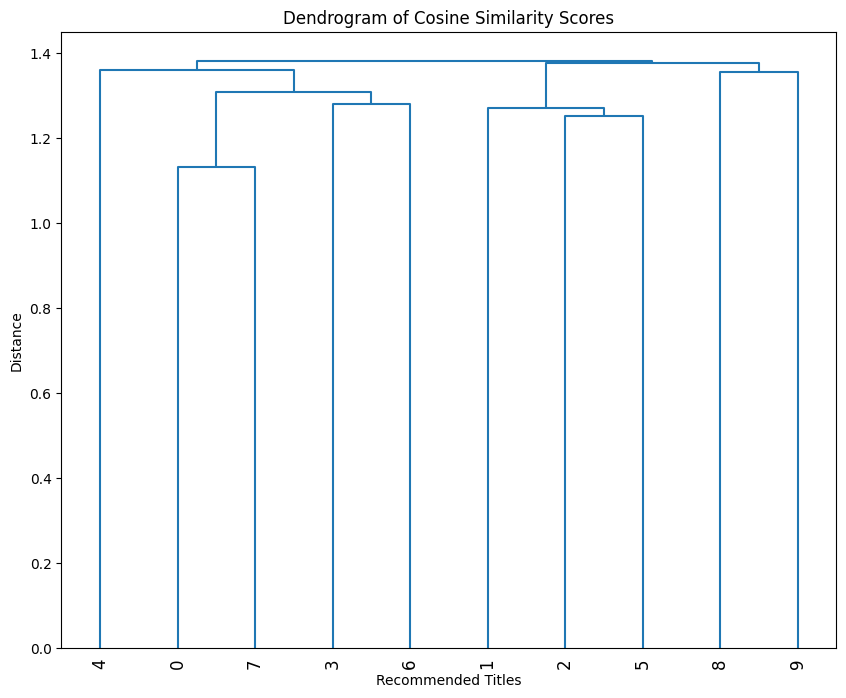

In [14]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(cosine_similarity_sparse, method='average')
# Plot dendrogram
plt.figure(figsize=(10, 8))
dn = hierarchy.dendrogram(Z,  leaf_rotation=90)
plt.title('Dendrogram of Cosine Similarity Scores')
plt.xlabel('Recommended Titles')
plt.ylabel('Distance')
plt.show()

In [15]:
def diversity(recommended_titles_list):
    total_similarity = 0
    total_pairs = 0

    for i in range(len(recommended_titles_list)):
        for j in range(i + 1, len(recommended_titles_list)):
            title1_words = set(recommended_titles_list[i].lower().split())
            title2_words = set(recommended_titles_list[j].lower().split())
            intersection = len(title1_words.intersection(title2_words))
            union = len(title1_words.union(title2_words))
            similarity = intersection / union if union > 0 else 0
            
            # Accumulate similarity scores and count pairs
            total_similarity += similarity
            total_pairs += 1

    # Calculate the average similarity between title pairs
    avg_similarity = total_similarity / total_pairs if total_pairs > 0 else 0
    # Calculate the diversity by subtracting the average similarity from 1
    diversity = 1 - avg_similarity
    return diversity

diversity_value = diversity(recommended_titles)
print(f"Diversity: {diversity_value:.2f}")


Diversity: 0.91


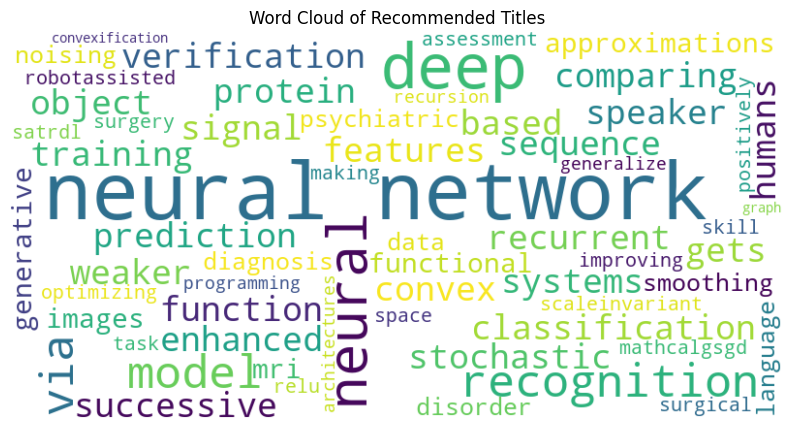

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Recommended titles as a single string
recommended_titles_text = " ".join(recommended_titles)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(recommended_titles_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Recommended Titles')
plt.show()
#The more frequently a word appears in the text, the larger it appears in the word cloud. 
#It provides a quick and intuitive way to identify the most common or prominent words in a given dataset or text corpus. 
#In the context of recommended titles, a word cloud can help visualize which titles are most frequently recommended, 
#with larger words indicating higher frequency of recommendation.


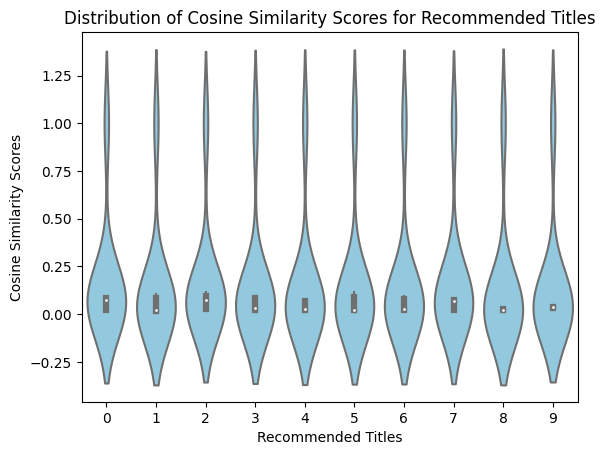

In [17]:
import seaborn as sns
#whitedot - median
#they are same as boxplot - 5 number summary
#thick gray bar - interquartile range
#thin gray line - distribution
#wider sections of the violin represent the higher probability that members has taken the given value
#skinnier sections represent the lower probability
# Create a violin plot
sns.violinplot(data=cosine_similarity_sparse, color='skyblue')
plt.xlabel('Recommended Titles')
plt.ylabel('Cosine Similarity Scores')
plt.title('Distribution of Cosine Similarity Scores for Recommended Titles')
plt.show()
